# Environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
class Maze:
    '''Class defining the environment'''
    def __init__(self, shapex, shapey, holes, start, goal):
        self.shapex = shapex
        self.shapey = shapey
        self.walls  = walls
        self.start  = start
        self.goal   = goal
        self.idx    = self.build_index()
        self.size   = shapex * shapey
        self.bitmap = self.build_bitmap()
        
    def state_from_index(self, number):
        '''get state from index'''
        x = number // self.shapey
        y = number  % self.shapey
        
        return (x, y)
        
    def build_index(self):
        '''build index for indexing states'''
        return {(x, y) : self.shapey * x + y for x in range(self.shapex) 
                for y in range(self.shapey)}
        
    def build_bitmap(self):
        '''builds the bitmap for visualisation'''
        bitmap = np.ones((self.shapex, self.shapey))
        
        for wall in self.walls:
            bitmap[wall] = 0
        
        return bitmap
    
    def show_bitmap(self):
        '''shows the environment of holes and walkable path'''
        
        plt.imshow(self.bitmap)
    
    def show_path(self, path):
        '''
        path : list(tuple(int, int)) : sequence of states
        
        plots a given path onto the bitmap
        '''
        
        c0 = 5
        c1 = 6
        
        length    = len(path)
        maze      = self.bitmap.copy()
        fade      = np.linspace(c0, c1, num=length)
        
        for i in range(length):
            maze[path[i]] = fade[i]
            
        maze[self.start] = c0
        maze[self.goal]  = c1
        
        print(f"path length: {len(path)}")
        plt.imshow(maze)

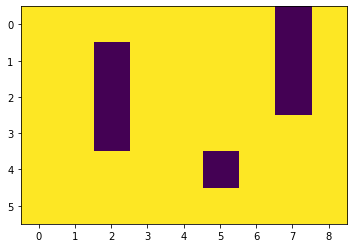

In [3]:
shapex = 6
shapey = 9
start  = (2, 0)
goal   = (0, 8)
walls  = [(1, 2), (2, 2), (3, 2), (4, 5), (0, 7), (1, 7), (2, 7)]

maze  = Maze(shapex, shapey, walls, start, goal)
maze.show_bitmap()

# Setup

In [4]:
moves     = [(-1, 0), (0, -1), (0, 1), (1, 0)]
move_idx  = {moves[i] : i for i in range(len(moves))}

In [5]:
def move(maze, pos, act):
    '''
    maze   : Maze            : Environment
    pos    : tuple(int, int) : Position in Environment
    act    : tuple(int, int) : Move direction
    
    Move from pos in direction act
    
    newpos : tuple(int, int) : New position
    '''
    
    oldpos = pos
    
    # Clamp values to map
    x_pos  = int(max(0, min(maze.shapex - 1, pos[0] + act[0])))
    y_pos  = int(max(0, min(maze.shapey - 1, pos[1] + act[1])))
    newpos = (x_pos, y_pos)
    
    # Reset position if falling in hole
    if newpos in maze.walls:
        newpos = oldpos
        
    reward = 1 if newpos == maze.goal else 0
    
    return newpos, reward

In [6]:
def epsilon_greedy_policy(Q, pos, epsilon=0.1):
    '''
    Q         : 3d np.array(), float : State-Action values
    pos       : tuple(int, int)      : Position in Environment
    epsilon   : float in [0, 1]      : Exploration / Exploitation Parameter
    
    Epsilon Greedy Policy. For a low epsilon value : high exploitation, low exploration
    
              : tuple(int, int)      : Decided Action according to policy
    '''
    
    global moves
    
    act_i = None
    r     = np.random.rand()
        
    if r > epsilon:
        act_i = np.argmax(Q[pos])
    else:
        act_i = np.random.randint(len(moves))
        
    return moves[act_i]

In [7]:
def trace(maze, Q):
    global moves
    
    S = maze.start
    A = moves[np.argmax(Q[S])]
    path = []
    
    while S != maze.goal:
        path.append(S)
        Sn, _ = move(maze, S, A)
        An    = moves[np.argmax(Q[Sn])]
        S     = Sn
        A     = An
        
        if Sn == maze.start or Sn in path:
            print("State Values dont create greedy path")
            break
    
    return path

# Dyna-Q

In [8]:
def dyna_q(maze=maze, plan_steps=50, episodes=8000, alpha=0.5, epsilon=0.1, gamma=1):
    global moves
    
    '''
    Suffixes: 
        - n: next
        - p: planning
        - m: max
        - i: index
    '''
    
    Q = np.zeros((maze.shapex, maze.shapey, len(moves)))
    M = np.zeros((maze.shapex, maze.shapey, len(moves), 3), dtype=int) # 3: reward (int) and state (tuple(int, int))
    S = maze.start
    
    history = [set()] * maze.size # History for planning part
    
    for episode in range(episodes):
        # Moving
        A     = epsilon_greedy_policy(Q, S)
        Sn, R = move(maze, S, A)
        if (len(history[maze.idx[S]]) != 4):
            history[maze.idx[S]].add(move_idx[A])
        
        # Direct Reinforcement Learning
        Am       = np.argmax(Q[Sn])
        idx      = (S[0],  S[1],  move_idx[A])
        idxn     = (Sn[0], Sn[1], Am)
        Q[idx]  += alpha * (R + gamma * Q[idxn] - Q[idx])
        
        # Model Learning
        M[idx]   = R, Sn[0], Sn[1]
        S        = Sn
        
        # Planning
        visited = [i for i, h in enumerate(history) if h]
        for step in range(plan_steps):
            Spi = random.choice(visited)
            Sp  = maze.state_from_index(Spi)
            Api = random.choice(tuple(history[Spi]))
            Rp  = M[Sp[0], Sp[1], Api, 0]
            Spn = tuple(M[Sp[0], Sp[1], Api, 1:])
            
            Apm     = np.argmax(Q[Spn])
            idx     = (Sp[0],  Sp[1],  Api)
            idxn    = (Spn[0], Spn[1], Apm)
            Q[idx] += alpha * (Rp + gamma * Q[idxn] - Q[idx])
            
    return Q, M

# Result

State Values dont create greedy path
path length: 3


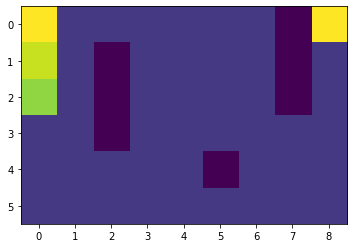

In [9]:
Q, M = dyna_q(plan_steps=10, episodes=10000)
path = trace(maze, Q)
maze.show_path(path)